In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from pylab import rcParams

rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

<span style="font-size: 24px;">**Stationarity**</span>

Time series data is said to be **stationary** if it does **not** exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.

Further Reading: [Forecasting: Principles and Practice](https://otexts.com/fpp2/stationarity.html)

In [3]:
df = pd.read_csv('../meta/samples.csv',index_col=0,parse_dates=True)
df.head()

,a,b,c
1950-01-01,36,27,0
1950-02-01,58,22,3
1950-03-01,61,17,5
1950-04-01,37,15,8
1950-05-01,66,13,8


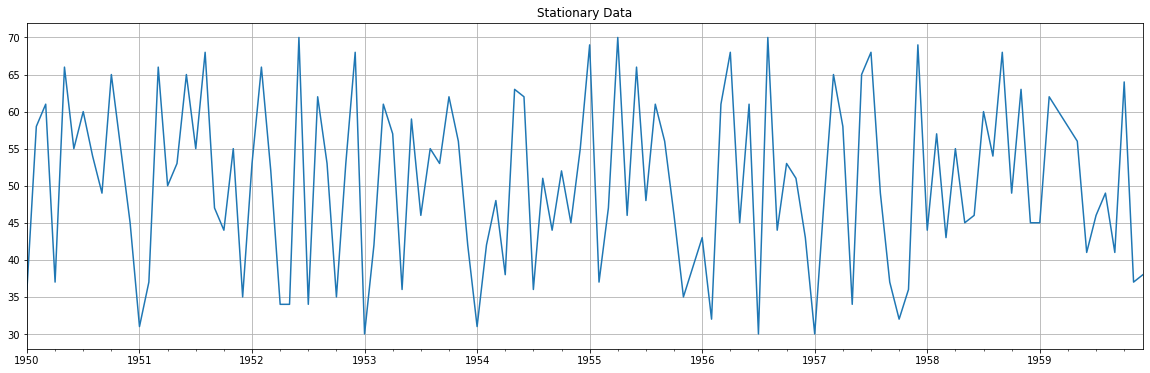

In [4]:
df['a'].plot(title="Stationary Data");

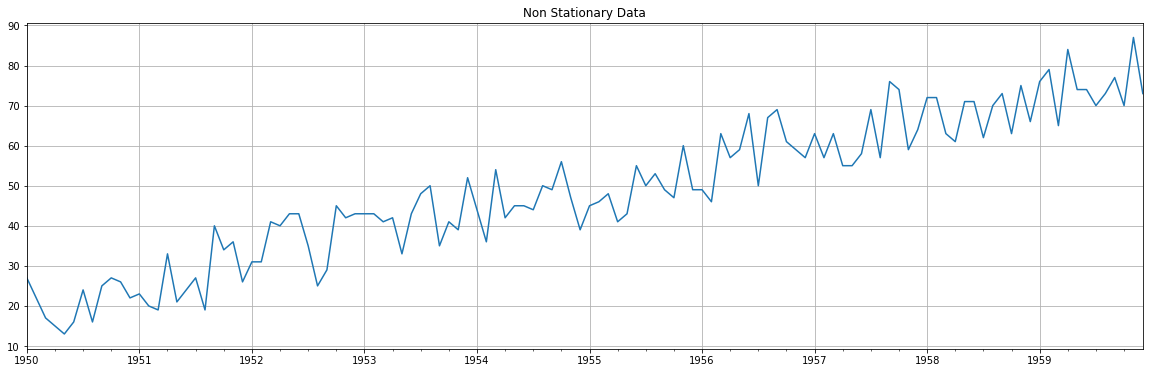

In [5]:
df['b'].plot(title="Non Stationary Data");

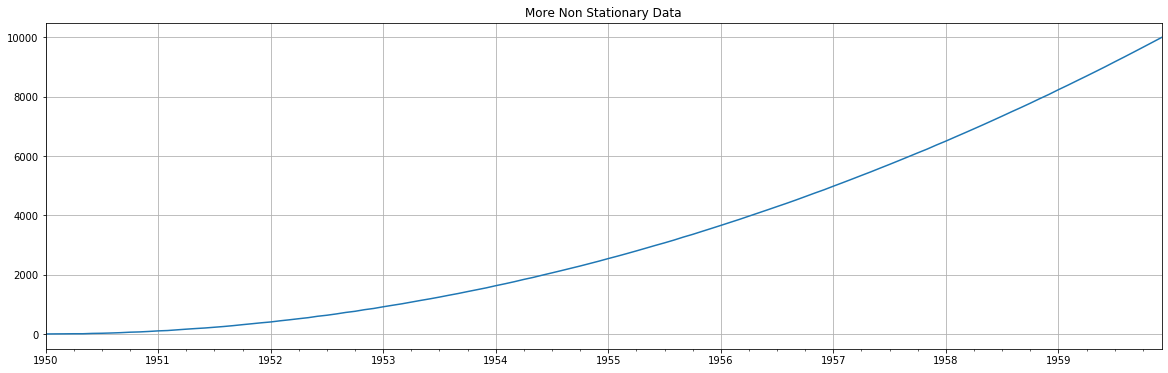

In [6]:
df['c'].plot(title="More Non Stationary Data");

<span style="font-size: 24px;">**Differencing**</span>

**First Order Differencing**

Non-stationary data can be made to look stationary through **differencing**. A simple method called **first order differencing** calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.

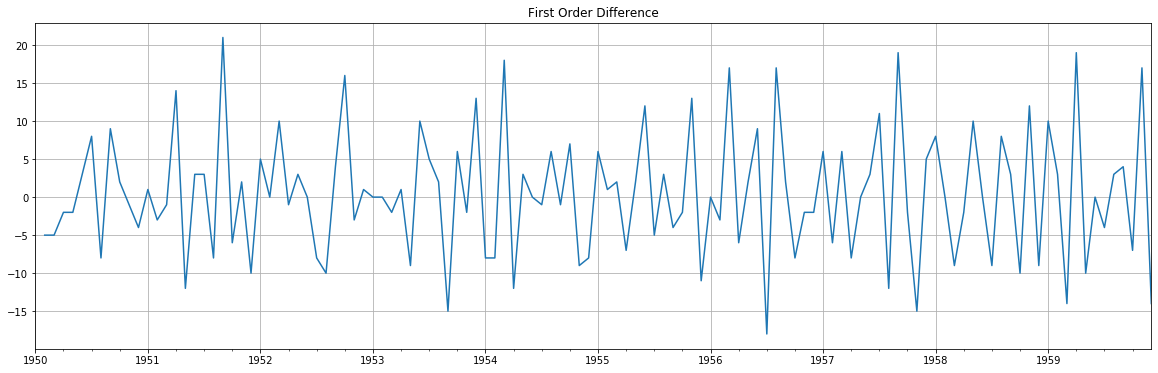

In [7]:
df['d1b'] = df['b'].diff()
df['d1b'].plot(title="First Order Difference");

**Forecasting on first order differenced data**

When forecasting with first order differences, the predicted values have to be added back in to the original values in order to obtain an appropriate forecast.

Let's say that the next five forecasted values after applying some model to `df['d1b']` are `[7,-2,5,-1,12]`. We need to perform an **inverse transformation** to obtain values in the scale of the original time series.

In [8]:
# For our example we need to build a forecast series from scratch
# First determine the most recent date in the training set, to know where the forecast set should start
df[['b']].tail(3)

,b
1959-10-01,70
1959-11-01,87
1959-12-01,73


In [9]:
# Next set a DateTime index for the forecast set that extends 5 periods into the future
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


The idea behind an inverse transformation is to start with the most recent value from the training set, and to add a cumulative sum of Fcast values to build the new forecast set. For this we'll use the pandas `.cumsum()` function which does the reverse of `.diff()`

In [10]:
z['forecast']=df['b'].iloc[-1] + z['Fcast'].cumsum()
z

,Fcast,forecast
1960-01-01,7,80
1960-02-01,-2,78
1960-03-01,5,83
1960-04-01,-1,82
1960-05-01,12,94


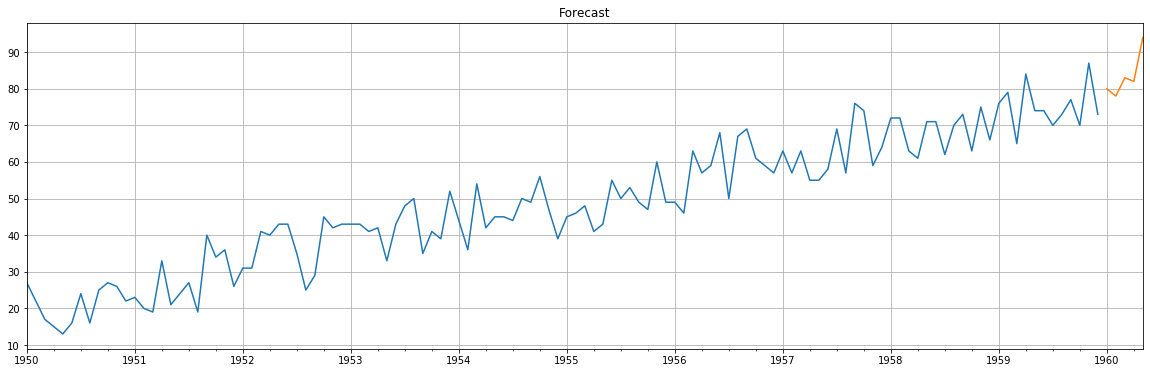

In [11]:
df['b'].plot(title="Forecast")
z['forecast'].plot();

**Second order differencing**

Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

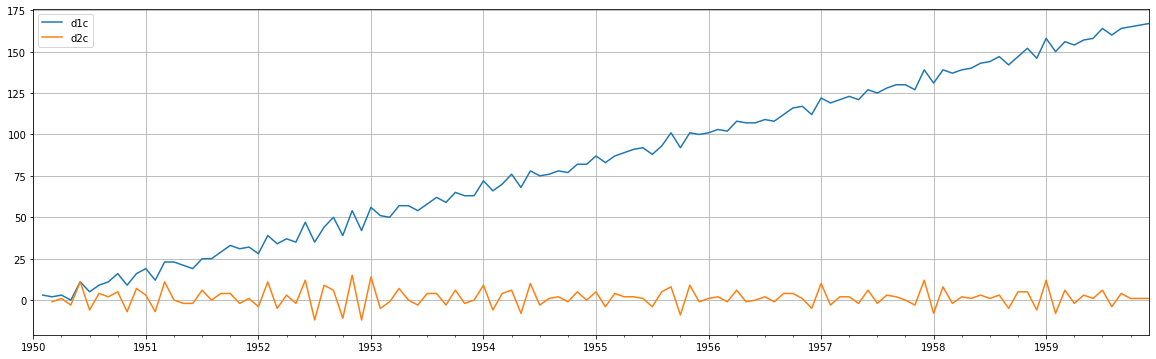

In [12]:
df['d1c'] = df['c'].diff()
df['d2c'] = df['c'].diff().diff()

df[['d1c', 'd2c']].plot();

**Forecasting on second order differenced data**

As before, the prediction values have to be added back in to obtain an appropriate forecast.

To invert the second order transformation and obtain forecasted values for $\hat y_t$ we have to solve the second order equation for $y_t$:

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_t - 2y_{t-1} + y_{t-2} \\
y_t &= y_{t}^{\prime\prime} + 2y_{t-1} - y_{t-2}\end{split}$

Let's say that the next five forecasted values after applying some model to `df['d2c']` are `[7,-2,5,-1,12]`.

In [13]:
# For our example we need to build a forecast series from scratch
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


In [14]:
forecast = []

# Capture the two most recent values from the training set
v2,v1 = df['c'].iloc[-2:]

# Apply the formula
for i in z['Fcast']:
    newval = i + 2*v1 - v2
    forecast.append(newval)
    v2,v1 = v1,newval

z['forecast']=forecast
z

,Fcast,forecast
1960-01-01,7,10174
1960-02-01,-2,10346
1960-03-01,5,10523
1960-04-01,-1,10699
1960-05-01,12,10887


In [15]:
# Add the most recent first difference from the training set to the Fcast cumulative sum
z['firstdiff'] = (df['c'].iloc[-1]-df['c'].iloc[-2]) + z['Fcast'].cumsum()

# Now build the forecast values from the first difference set
z['forecast'] = df['c'].iloc[-1] + z['firstdiff'].cumsum()

z[['Fcast','firstdiff','forecast']]

,Fcast,firstdiff,forecast
1960-01-01,7,174,10174
1960-02-01,-2,172,10346
1960-03-01,5,177,10523
1960-04-01,-1,176,10699
1960-05-01,12,188,10887


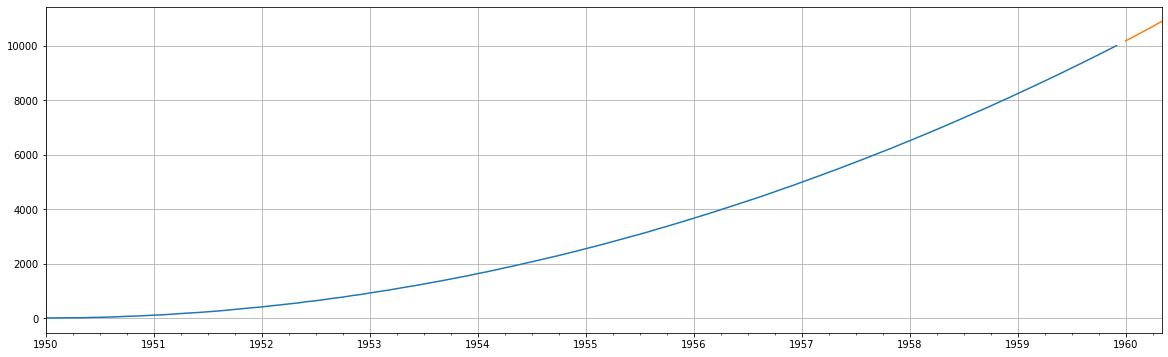

In [16]:
df['c'].plot()
z['forecast'].plot();

<span style="font-size: 24px;">**Lagging**</span>

Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing regressions

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>
